# DQN Classifier: 

Énoncé : Adapter l’agent-DQN de la question 2.4 ou créer un nouveau pour réaliser la même tâche
(classification ou de prédiction) que l’agent-supervisé de la question 2.6. Les entrées de cet agent
doivent être les mêmes données (observations) que celles utilisées dans l’agent supervisé. Une idée
pour le système de récompense, si l’agent réalise une classification ou une prédiction proche de la
classification ou de la prédiction espérée, alors la récompense sera par exemple de +1 sinon c’est une
pénalité (-1). 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from dataclasses import dataclass
import time

In [2]:
data = np.load("/content/sup_dataset.npz")
X = data["X"].astype(np.float32)
y = data["y"].astype(np.int32)

print(X.shape, y.shape, np.unique(y, return_counts=True))


(430867, 7) (430867,) (array([0, 1, 2], dtype=int32), array([268901,  81143,  80823]))


In [3]:
N = X.shape[0]
idx = np.arange(N)
np.random.shuffle(idx)

train_ratio = 0.8
n_train = int(train_ratio * N)
train_idx = idx[:n_train]
val_idx   = idx[n_train:]

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val     = X[val_idx], y[val_idx]


In [4]:
class DatasetEnv:
    def __init__(self, X, y, episode_len=200, shuffle=True):
        self.X = X
        self.y = y
        self.N = len(X)
        self.episode_len = episode_len
        self.shuffle = shuffle
        self.reset()

    def reset(self):
        self.t = 0
        self.order = np.arange(self.N)
        if self.shuffle:
            np.random.shuffle(self.order)
        self.ptr = 0
        return self.X[self.order[self.ptr]]

    def step(self, action):
        label = self.y[self.order[self.ptr]]
        reward = 1.0 if int(action) == int(label) else -1.0

        self.ptr += 1
        self.t += 1

        done = (self.t >= self.episode_len) or (self.ptr >= self.N-1)
        next_obs = self.X[self.order[self.ptr]] if not done else np.zeros_like(self.X[0])

        info = {"label": int(label), "correct": int(reward > 0)}
        return next_obs, reward, done, info


In [5]:
def build_q_network(state_dim, n_actions):
    inputs = layers.Input(shape=(state_dim,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(n_actions, activation=None)(x)  # Q(s,a)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.Huber()
    )
    return model


In [6]:
class ReplayBuffer:
    def __init__(self, state_dim, capacity=50_000):
        self.capacity = capacity
        self.state_dim = state_dim
        self.ptr = 0
        self.size = 0

        self.states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.actions = np.zeros((capacity,), dtype=np.int32)
        self.rewards = np.zeros((capacity,), dtype=np.float32)
        self.next_states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.dones = np.zeros((capacity,), dtype=np.float32)

    def store(self, s, a, r, ns, d):
        i = self.ptr
        self.states[i] = s
        self.actions[i] = a
        self.rewards[i] = r
        self.next_states[i] = ns
        self.dones[i] = float(d)
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (self.states[idx], self.actions[idx], self.rewards[idx],
                self.next_states[idx], self.dones[idx])


In [7]:
def select_action(state, q_network, n_actions, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(0, n_actions)
    q = q_network(state[None, :]).numpy()[0]
    return int(np.argmax(q))


In [8]:
def train_step(buffer, batch_size, gamma, q_network, target_network, n_actions):
    if buffer.size < batch_size:
        return None

    s, a, r, ns, d = buffer.sample(batch_size)

    next_q = target_network(ns).numpy()
    max_next_q = np.max(next_q, axis=1)

    targets = r + gamma * (1.0 - d) * max_next_q

    q = q_network(s).numpy()
    batch_idx = np.arange(batch_size)
    q[batch_idx, a] = targets

    loss = q_network.train_on_batch(s, q)
    return float(loss)


In [9]:
state_dim = X_train.shape[1]
n_actions = int(np.max(y_train)) + 1

env = DatasetEnv(X_train, y_train, episode_len=200, shuffle=True)

q_net = build_q_network(state_dim, n_actions)
t_net = build_q_network(state_dim, n_actions)
t_net.set_weights(q_net.get_weights())

buffer = ReplayBuffer(state_dim, capacity=50_000)

n_episodes = 300
batch_size = 64
gamma = 0.0
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 200
target_update = 500

logs = {"return": [], "acc": [], "loss": [], "eps": []}
total_steps = 0

t0 = time.time()

for ep in range(n_episodes):
    s = env.reset()
    done = False
    ep_ret = 0.0
    correct = 0
    steps = 0
    ep_losses = []

    frac = min(1.0, ep / epsilon_decay)
    eps = epsilon_start + frac * (epsilon_end - epsilon_start)

    while not done:
        a = select_action(s, q_net, n_actions, eps)
        ns, r, done, info = env.step(a)

        buffer.store(s, a, r, ns, done)
        s = ns
        ep_ret += r
        correct += info["correct"]
        steps += 1
        total_steps += 1

        loss = train_step(buffer, batch_size, gamma, q_net, t_net, n_actions)
        if loss is not None:
            ep_losses.append(loss)

        if total_steps % target_update == 0:
            t_net.set_weights(q_net.get_weights())

    logs["return"].append(ep_ret)
    logs["acc"].append(correct / steps)
    logs["loss"].append(np.mean(ep_losses) if ep_losses else np.nan)
    logs["eps"].append(eps)

    if (ep+1) % 20 == 0:
        print(f"Ep {ep+1}/{n_episodes} | eps={eps:.3f} | return={ep_ret:.1f} | acc={logs['acc'][-1]:.3f}")

train_seconds = time.time() - t0
print("Training time (s):", train_seconds)


Ep 20/300 | eps=0.910 | return=-34.0 | acc=0.415
Ep 40/300 | eps=0.815 | return=-40.0 | acc=0.400
Ep 60/300 | eps=0.720 | return=22.0 | acc=0.555
Ep 80/300 | eps=0.625 | return=36.0 | acc=0.590
Ep 100/300 | eps=0.530 | return=36.0 | acc=0.590
Ep 120/300 | eps=0.435 | return=42.0 | acc=0.605
Ep 140/300 | eps=0.340 | return=78.0 | acc=0.695
Ep 160/300 | eps=0.245 | return=90.0 | acc=0.725
Ep 180/300 | eps=0.150 | return=106.0 | acc=0.765
Ep 200/300 | eps=0.055 | return=116.0 | acc=0.790
Ep 220/300 | eps=0.050 | return=136.0 | acc=0.840
Ep 240/300 | eps=0.050 | return=130.0 | acc=0.825
Ep 260/300 | eps=0.050 | return=134.0 | acc=0.835
Ep 280/300 | eps=0.050 | return=122.0 | acc=0.805
Ep 300/300 | eps=0.050 | return=128.0 | acc=0.820
Training time (s): 807.0853524208069


In [10]:
def eval_accuracy(X, y, q_network):
    preds = []
    for i in range(len(X)):
        q = q_network(X[i][None, :]).numpy()[0]
        preds.append(int(np.argmax(q)))
    preds = np.array(preds, dtype=np.int32)
    return float((preds == y).mean())

val_acc = eval_accuracy(X_val, y_val, q_net)
print("VAL accuracy:", val_acc)


VAL accuracy: 0.8633346485018684


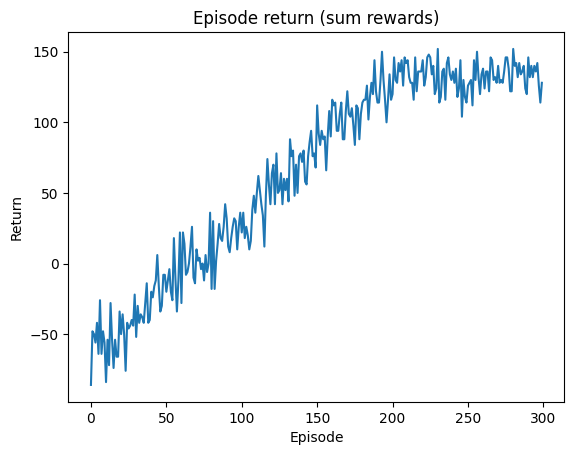

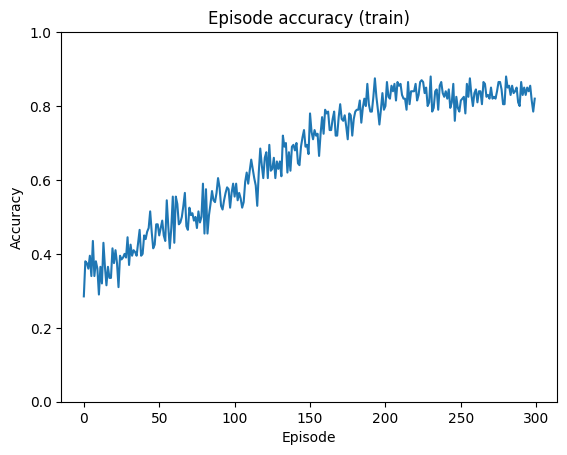

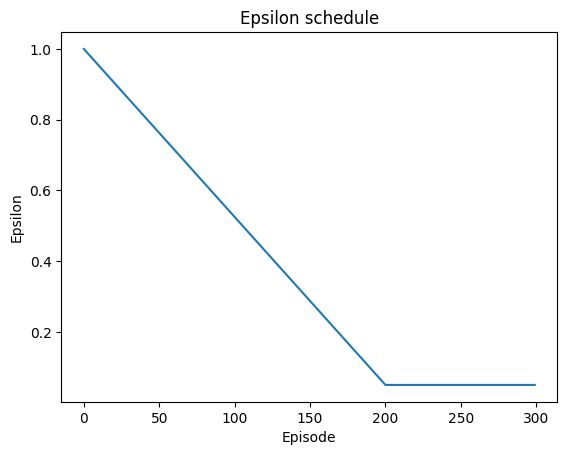

In [11]:
plt.figure()
plt.plot(logs["return"])
plt.title("Episode return (sum rewards)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.show()

plt.figure()
plt.plot(logs["acc"])
plt.title("Episode accuracy (train)")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

plt.figure()
plt.plot(logs["eps"])
plt.title("Epsilon schedule")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()


In [ ]:
plt.figure()
plt.plot(logs["acc"])
plt.title("Episode accuracy (train)")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_qnet_learning_curves(logs, title_prefix="Supervised Q-Net"):
    returns = np.asarray(logs["episode_returns"], dtype=np.float32)
    sr      = np.asarray(logs["success_rate_curve"], dtype=np.float32)

    plt.figure()
    plt.plot(returns)
    plt.title(f"{title_prefix} - Episode return")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.show()

    plt.figure()
    plt.plot(sr)
    plt.title(f"{title_prefix} - Success rate curve")
    plt.xlabel("Episode")
    plt.ylabel("Success rate")
    plt.ylim(0, 1)
    plt.show()

    if "cumulative_seconds" in logs:
        t = np.asarray(logs["cumulative_seconds"], dtype=np.float32)
        plt.figure()
        plt.plot(t)
        plt.title(f"{title_prefix} - Cumulative training time")
        plt.xlabel("Episode")
        plt.ylabel("Seconds")
        plt.show()

def qnet_predict_actions(q_model, X, batch_size=2048):
    preds = []
    for i in range(0, len(X), batch_size):
        xb = X[i:i+batch_size].astype(np.float32)
        q  = q_model(xb).numpy()          # (B, 3)
        preds.append(np.argmax(q, axis=1))
    return np.concatenate(preds).astype(np.int32)

def confusion_matrix_np(y_true, y_pred, n_classes=3):
    cm = np.zeros((n_classes, n_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def plot_confusion_matrix(cm, class_names=("0", "1", "2"), title="Confusion matrix", normalize=True):
    cm_plot = cm.astype(np.float32)
    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        cm_plot = np.divide(cm_plot, np.maximum(row_sums, 1.0))

    plt.figure()
    plt.imshow(cm_plot, interpolation="nearest")
    plt.title(title + (" (normalized)" if normalize else ""))
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # annotations
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = cm_plot[i, j]
            txt = f"{val:.2f}" if normalize else str(int(cm[i, j]))
            plt.text(j, i, txt, ha="center", va="center")

    plt.tight_layout()
    plt.show()

def evaluate_qnet_on_dataset(q_model, X, y, name="Supervised Q-Net"):
    y_pred = qnet_predict_actions(q_model, X)
    acc = float((y_pred == y).mean())
    cm  = confusion_matrix_np(y, y_pred, n_classes=3)
    print(f"[{name}] accuracy = {acc:.4f}")
    plot_confusion_matrix(cm, class_names=("0", "1", "2"),
                          title=f"{name} - Confusion matrix", normalize=True)
    return acc, cm


[QNet (2.8)] accuracy = 0.8633


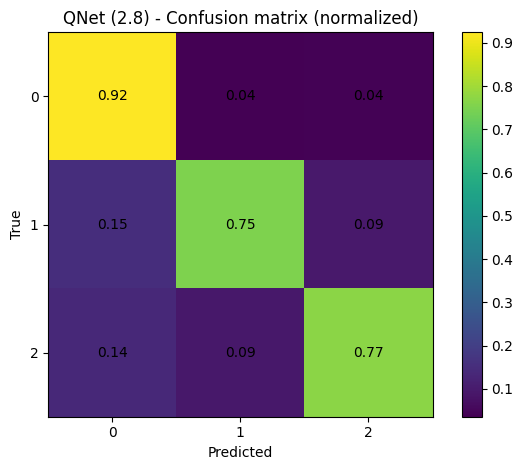

In [16]:
acc_val, cm_val = evaluate_qnet_on_dataset(q_net, X_val, y_val, name="QNet (2.8)")


In [14]:
q_net.save("supervised_q_net.h5")